In [1]:
import numpy as np
import pandas as pd

import data_manipulation as dm
import time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Import datasets
txn_og = dm.transactions()
train = dm.train()
test = pd.read_csv('../new_sample_submission_zero.csv')
ul_var = pd.read_csv('../final_user_log.csv')

In [39]:
train[train['new_id']==217]

,is_churn,new_id,in_txn
589255,0,217,True


In [3]:
#Prep - sort transactions
txn_og = txn_og.sort_values(['new_id', 'transaction_date', 'membership_expire_date'])
#Prep - limit transactions to end of Jan
txn=txn_og[txn_og['transaction_date']<='2017-01-31']

In [4]:
#Some members in test group don't have any transactions. All members in train group have transactions.
#88k members in test gorup also in train group.
test['in_txn']=test['new_id'].isin(txn_og['new_id'])
train['in_txn']=train['new_id'].isin(txn_og['new_id'])
test['in_train']=test['new_id'].isin(train['new_id'])
print(test['in_txn'].value_counts())
print(train['in_txn'].value_counts())
print(test['in_train'].value_counts())

True     968433
False      2527
Name: in_txn, dtype: int64
True    992931
Name: in_txn, dtype: int64
True     881701
False     89259
Name: in_train, dtype: int64


In [5]:
#Check datasets
print(train.shape)
print(test.shape)
print(txn_og.shape)
print(ul_var.shape)
print(train['new_id'].nunique())
print(txn_og['new_id'].nunique())
print(test['new_id'].nunique())

(992931, 3)
(970960, 4)
(16411725, 9)
(992931, 8)
992931
1079663
970960


In [6]:
txn_og['in_train']=txn_og['new_id'].isin(train['new_id'])
txn['in_train']=txn['new_id'].isin(train['new_id'])
txn_og['in_test']=txn_og['new_id'].isin(test['new_id'])
txn['in_test']=txn['new_id'].isin(test['new_id'])

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
#Seems like 31,497 users only have transactions in Feb
#2,097 users that are in train only have transactions in Feb
#30,616 users that are in test only have transactions in Feb
print((txn_og[(txn_og['in_train']==True)]['new_id'].nunique()) - (txn[txn['in_train']==True]['new_id'].nunique()))
print((txn_og[(txn_og['in_test']==True)]['new_id'].nunique()) - (txn[txn['in_test']==True]['new_id'].nunique()))

2097
30616


In [10]:
print(max(txn[txn['in_train']==True]['membership_expire_date']))

2017-03-31 00:00:00


## Investigating Transactions

*Looking into transactions where the membership_expiry_date < transaction_date*

In [ ]:
#Adding some features
#txn['in_train']=txn['new_id'].isin(train['new_id'])
#txn['odd_transactions']=txn['membership_expire_date']<txn['transaction_date']
#txn['1970']=txn['membership_expire_date']=='1970-01-01'
#txn['in_train'].value_counts()

In [ ]:
pd.crosstab(index=txn['odd_transactions'], columns=txn['in_train'], normalize='index')

In [ ]:
#Odd transactions are more likely to be auto renew transactions
pd.crosstab(index=txn['odd_transactions'], columns=txn['is_auto_renew'], normalize='index')

In [ ]:
#Odd transactions are more likely to be cancelled transactions
pd.crosstab(index=txn['odd_transactions'], columns=txn['is_cancel'], normalize='index')

In [ ]:
#397 of the odd transactions are caused by '1970'
pd.crosstab(index=txn['odd_transactions'], columns=txn['1970'], normalize='index')
pd.crosstab(index=txn['odd_transactions'], columns=txn['1970'])

In [ ]:
#226 bad transactions are in the training set
pd.crosstab(index=txn['in_train'], columns=txn['1970'])

In [ ]:
#0.4% of transactions have membership_expire_date<transaction_date
memb_exp_test=txn[txn['membership_expire_date']<txn['transaction_date']]
print(memb_exp_test.shape[0])
print(txn.shape[0])
print(memb_exp_test.shape[0]/txn.shape[0])
print(txn['new_id'].nunique())
print(memb_exp_test['new_id'].nunique())

In [ ]:
#Almost all records with membership_expire_date<transaction_date are auto_renew memberships
print(memb_exp_test[memb_exp_test['is_auto_renew']==1]['is_auto_renew'].sum())
print(txn[txn['is_auto_renew']==1].shape)

In [ ]:
#Most of the records with membership_expire_date<transaction_date are cancelled memberships - are these late payments?
#ALL of these are also auto-renew memberships
print(memb_exp_test[memb_exp_test['is_cancel']==1]['is_cancel'].sum())
memb_exp_test[(memb_exp_test['is_cancel']==1)&(memb_exp_test['is_auto_renew']==1)].shape

In [ ]:
#The rest of the auto_renew memberships
memb_exp_test[(memb_exp_test['is_cancel']==0)&(memb_exp_test['is_auto_renew']==1)].shape

In [ ]:
#Looks like the rest of the records have lots of instances of membership_expire_date = '1970-01-01'
memb_exp_test[memb_exp_test['is_auto_renew']==0].head(10)
#15 records where membership_expire_date is not is not 1970-01-01 and is not auto_renew
odd_ones_out=memb_exp_test[(memb_exp_test['membership_expire_date']!='1970-01-01') & (memb_exp_test['is_auto_renew']==0)]
#Seems like all of these have plan_list_price of 0
odd_ones_out.head(15)

In [ ]:
#is_cancel=txn[txn['is_cancel']==1]
#print(is_cancel.shape)
#is_cancel['diff_dates']=is_cancel['membership_expire_date']-is_cancel['transaction_date']
#is_cancel['diff_dates']=is_cancel['diff_dates']/ np.timedelta64(1, 'D')
#sns.distplot(is_cancel[is_cancel['diff_dates']>0]['diff_dates'])

In [ ]:
#Determine if member had an odd transaction
txn['odd_txn_flag'] = txn['new_id'].isin(memb_exp_test['new_id'])

## Feature Engineering
 
<font color='red'>*Note that for the test group, we'll have access to less transactions - using transactions up to March 31st 2017 to predict memberships that expire in April 2017. Therefore, we should train using data up to the end of Feb to predict churn for memberships that expire in the month of March 2017.*</font>

Each transaction feature is stored in a pandas dataframe:

- **txn_cnts (all members)**: Count number of transactions per member; note that this dataframe is no longer included since the transaction count is in the txn_lp_high dataframe
- **tot_plan_pmt (all members)**: Sum of payment plan days, plan list price, and actual amount paid. Also - average price per day, and difference between plan list price and actual amount paid
- **txn_lp_high (all members)**: Count of, and percentage of transactions that have higher list price than actual amount paid
- **txn_prev_churn (churned members)**: Count number of times members churned, i.e. transaction date - membership expire date from previous transaction is greater than 30 days
- **txn_ar_stop (all members)**: % of transactions that are auto renew and whether a member has stopped auto-renewing in the duration of their membership
- **txn_pmt_change (payment change members)**: Count number of times member changed payment type 
- **txn_cancelled (all members)**: % of transactions that are cancelled and whether a members has cancelled their membership in the duration of their membership
- **txn_cancelled_last (all members)**: If the member has a cancelled transaction as their last transaction
- **last_txn (all_members)**: If the member has a free trial as their last transaction

- % of transactions that are free trials
- % of payment plan days that are free trials
- member tenure

All dfs are to be merged into one df, for transaction attributes per member

Next:
- Look at payment plan days - how often are these 0?
- Last transaction is a free trial - free trial and only one transaction: how does this relate to churn?
- Which is the "current" transaction?
- Number of transactions where plan_list_price != actual_amount_paid?
- Transactions matrix


1. Members in train who have membership_expiry date beyond March (for new dataset) - remove, for sure not churn
Train members: anybody who has a membership_expiry_date in Feb 2017
     March 31st seems to be the max membership_expire_date for members in train
     Feature: boolean membership_expire_date>Feb 2017
     What does it mean???
Test members: anybody who has a membership_expiry_date in March 2017
New train members: anybody who has a membership_expiry_date in March 2017
New test members: anybody who has a membership_expiry_date in April 2017
       How many members have this behaviour?

2. When people have a transaction with membership_expiry_date that is smaller than transaction date, what does the userlog data look like? Are they still listeninging after the membership has supposedly expired?

### Number of Transactions

In [54]:
#Number of transactions
txn_cnts = txn.groupby(['new_id']).size().reset_index(name='txn_cnt')

### Total Payment Plan Days, Plan List Price, Actual Amount Paid

In [55]:
#Sum of payment_plan_days
tot_plan_pmt = txn.groupby(['new_id'])[['payment_plan_days', 'plan_list_price', 'actual_amount_paid']].sum().reset_index()
tot_plan_pmt['avg_daily_paid'] = tot_plan_pmt['actual_amount_paid'] / tot_plan_pmt['payment_plan_days']
tot_plan_pmt['list_actual_diff'] = tot_plan_pmt['plan_list_price'] - tot_plan_pmt['actual_amount_paid']
tot_plan_pmt.head()

,new_id,payment_plan_days,plan_list_price,actual_amount_paid,avg_daily_paid,list_actual_diff
0,0,90,297,297,3.300000,0
1,1,543,2682,2831,5.213628,65387
2,2,720,3576,3725,5.173611,65387
3,3,330,1639,1639,4.966667,0
4,4,543,2682,2831,5.213628,65387


### Number, and Percentage of Transactions where Plan List Price Higher than Actual Amount Paid

In [57]:
#Note that plan_list_price is never lower than actual_amount_paid
txn['list_actual_diff'] = txn['plan_list_price'] - txn['actual_amount_paid']
txn_lp_high = txn[txn['list_actual_diff'] > 0].groupby('new_id')['list_actual_diff'].count().reset_index(name='lp_high_cnt')
txn_lp_high = txn_cnts.merge(txn_lp_high, on = 'new_id', how = 'left')
txn_lp_high['per_lp_high'] = txn_lp_high['lp_high_cnt']/txn_lp_high['txn_cnt']
txn_lp_high.drop('lp_high_cnt', axis = 1, inplace = True)
txn_lp_high.head()

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,new_id,txn_cnt,per_lp_high
0,0,3,NaN
1,1,19,0.052632
2,2,25,0.040000
3,3,11,NaN
4,4,19,0.052632


### Number of Times Churned

In [58]:
#Previous churn: determine if transaction date-membership expiry date from previous row is >30days 
txn['shifted_expiry'] = txn.groupby('new_id')['membership_expire_date'].shift()
txn['memb_gap'] = (txn['transaction_date'] - txn['shifted_expiry'])
txn['prev_churn'] = (txn['memb_gap']/np.timedelta64(1, 'D'))>30
txn.head()

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,new_id,in_train,list_actual_diff,shifted_expiry,memb_gap,prev_churn
0,41,30,129,129,1,2015-09-30,2015-11-01,0,625225,True,0,NaT,NaT,False
1,41,30,129,129,1,2015-10-31,2015-12-01,0,625225,True,0,2015-11-01,-1 days,False
2,41,30,129,129,1,2015-06-30,2015-08-01,0,625225,True,0,2015-12-01,-154 days,False
3,41,30,129,129,1,2015-02-28,2015-04-01,0,625225,True,0,2015-08-01,-154 days,False
4,41,30,129,129,1,2016-11-30,2017-01-01,0,625225,True,0,2015-04-01,609 days,True


In [63]:
#Aggregate number of times churned
txn_prev_churn = txn[txn['prev_churn'] == True].groupby('new_id')['prev_churn'].count().reset_index(name='prev_churn_cnt')
txn_prev_churn = txn_prev_churn.merge(txn_cnts, on='new_id', how='inner')
txn_prev_churn['prev_churn_per'] = txn_prev_churn['prev_churn_cnt'] / txn_prev_churn['txn_cnt']
txn_prev_churn.drop(['prev_churn_cnt', 'txn_cnt'], axis = 1, inplace = True)
txn_prev_churn.head()

,new_id,prev_churn_per
0,1,0.368421
1,2,0.440000
2,3,0.363636
3,4,0.421053
4,5,0.476190


### Stopped Auto Renew

In [64]:
#Value of 'is_auto_renew' for last transaction
txn_ar_last = txn.groupby(['new_id'])['is_auto_renew'].last().reset_index(name='last_ar')
txn_ar_last['last_ar'].value_counts()

1    880816
0    167350
Name: last_ar, dtype: int64

In [65]:
#Changed auto renew:
txn_ar_change = txn.groupby(['new_id'])['is_auto_renew'].mean().reset_index(name='mean_ar')
txn_ar_stop = txn_ar_change.merge(txn_ar_last, on='new_id', how='inner')
txn_ar_stop['stopped_ar']=(txn_ar_stop['mean_ar'] < 1) & (txn_ar_stop['mean_ar'] > 0) & (txn_ar_stop['last_ar'] == 0)
txn_ar_stop[txn_ar_stop['stopped_ar']==True].head()

,new_id,mean_ar,last_ar,stopped_ar
21,21,0.962963,0,True
122,125,0.428571,0,True
200,207,0.916667,0,True
244,252,0.375000,0,True
257,265,0.875000,0,True


In [66]:
txn_ar_stop.drop('last_ar', axis = 1, inplace = True)
txn_ar_stop['stopped_ar'].value_counts()

False    1021015
True       27151
Name: stopped_ar, dtype: int64

### Changed Payment Method

In [67]:
#Changed payment method:determine if transaction date-membership expiry date from previous row is >30days 
txn['shifted_pmt'] = txn.groupby('new_id')['payment_method_id'].shift()
txn['pmt_change'] = (txn['payment_method_id'] != txn['shifted_pmt']) & (txn['shifted_pmt'].isnull() != True)
txn['pmt_change'].value_counts()

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


False    14805039
True       700255
Name: pmt_change, dtype: int64

In [68]:
#Aggregate number of times changed payment method
txn_pmt_change = txn[txn['pmt_change'] == True].groupby('new_id')['pmt_change'].count().reset_index(name='pmt_change_cnt')
txn_pmt_change.head()

,new_id,pmt_change_cnt
0,7,2
1,8,1
2,9,2
3,21,10
4,36,6


### Cancelled Membership

In [71]:
#Cancelled membership:
txn_cancelled = txn.groupby(['new_id'])['is_cancel'].mean().reset_index(name='mean_cancel')
txn_cancelled.head()

,new_id,mean_cancel
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [72]:
#Cancelled membership in last transaction:
txn_cancelled_last = txn.groupby(['new_id'])['is_cancel'].last().reset_index(name='last_cancel')
txn_cancelled_last['last_cancel'].value_counts()

0    1032856
1      15310
Name: last_cancel, dtype: int64

### Last Transaction is Free Trial

In [74]:
#5483 members who have their last transaction as a free trial
last_txn = txn.groupby(['new_id'])['plan_list_price'].last().reset_index(name='last_plan_price')
last_txn['lst_free_trial'] = (last_txn['last_plan_price'] == 0) | (last_txn['last_plan_price'] == 1)
last_txn.drop('last_plan_price', axis = 1, inplace = True)
last_txn[last_txn['lst_free_trial']==True].head()

,new_id,lst_free_trial
17,17,True
21,21,True
36,36,True
77,80,True
101,104,True


### Max Membership Expire Date

In [24]:
#max_memb_expire
max_memb_expire = txn.groupby(['new_id'])['membership_expire_date'].max().reset_index(name='max_memb_expire')
lst_memb_expire = txn.groupby(['new_id'])['membership_expire_date'].last().reset_index(name='lst_memb_expire')
memb_expire = max_memb_expire.merge(lst_memb_expire, on = 'new_id', how = 'inner')

In [25]:
memb_expire['not_equal'] = memb_expire['max_memb_expire'] != memb_expire['lst_memb_expire']

In [27]:
txn_memb_expire = txn.merge(memb_expire, on = 'new_id', how = 'left')

In [34]:
txn_memb_expire[(txn_memb_expire['not_equal']==True) & (txn_memb_expire['new_id']==217)].head(100)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,new_id,in_train,in_test,max_memb_expire,lst_memb_expire,not_equal
3148,41,30,149,149,1,2015-01-19,2016-12-22,0,217,True,True,2017-03-19,2017-02-22,True
3149,41,30,149,149,1,2015-01-19,2017-01-22,0,217,True,True,2017-03-19,2017-02-22,True
3150,41,30,149,149,1,2015-02-19,2017-02-19,0,217,True,True,2017-03-19,2017-02-22,True
3151,41,30,149,149,1,2015-02-19,2017-03-19,0,217,True,True,2017-03-19,2017-02-22,True
3152,41,30,149,149,1,2015-12-24,2015-03-22,1,217,True,True,2017-03-19,2017-02-22,True
3153,41,30,129,129,1,2016-01-22,2016-02-22,0,217,True,True,2017-03-19,2017-02-22,True
3154,41,30,129,129,1,2016-02-22,2016-03-22,0,217,True,True,2017-03-19,2017-02-22,True
3155,41,30,149,149,1,2016-03-22,2016-04-22,0,217,True,True,2017-03-19,2017-02-22,True
3156,41,30,149,149,1,2016-04-22,2016-05-22,0,217,True,True,2017-03-19,2017-02-22,True
3157,41,30,149,149,1,2016-05-22,2016-06-22,0,217,True,True,2017-03-19,2017-02-22,True


## Merging Feature Dataframes

In [35]:
import functools

txn_features = [train, tot_plan_pmt, txn_ar_stop, txn_cancelled, txn_cancelled_last, last_txn, txn_lp_high, txn_prev_churn, txn_pmt_change]
f_txn = functools.reduce(lambda left,right: pd.merge(left,right,on='new_id', how='left'), txn_features)

f_txn.drop('in_txn', axis = 1, inplace = True)

print(f_txn.shape)
f_txn.head()

NameError: name 'tot_plan_pmt' is not defined

In [78]:
#2097 nulls
f_txn[(pd.isnull(f_txn['payment_plan_days']) == True)]['new_id'].nunique()

2097

In [79]:
f_txn.to_csv('../final_txn.csv', index=False)

## Casual Exploratory Analysis

Oh so casual *_hairflick_

In [ ]:
#4% of transactions have a plan_list_price of zero
txn[txn['plan_list_price']==0]['plan_list_price'].count()/txn['plan_list_price'].count()

In [ ]:
#Looking at prices of membership transactions: 99 & 149 & 129 corresponds to monthly membership
plt.figure(num=None, figsize=(16, 4), dpi=80)
sns.countplot(txn['plan_list_price'])

In [ ]:
print(txn[(txn['plan_list_price']==129)|(txn['plan_list_price']==99)|(txn['plan_list_price']==149)]['payment_plan_days'].value_counts())

In [ ]:
txn_test = txn.groupby(['plan_list_price', 'payment_plan_days'])['plan_list_price'].count().reset_index(name='cnt_txn')
txn_test = txn_test.pivot(index='plan_list_price', columns='payment_plan_days', values='cnt_txn')
plt.figure(num=None, figsize=(16, 10), dpi=80)
sns.heatmap(txn_test, cmap='viridis')

## Are Features Useful?

### Total Payment Plan Days

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'payment_plan_days', data=f_txn)

### Difference Between Listed and Paid Price

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'list_actual_diff', data=f_txn)

### Number of Transactions where Plan List Price is Higher than Actual Amount Paid

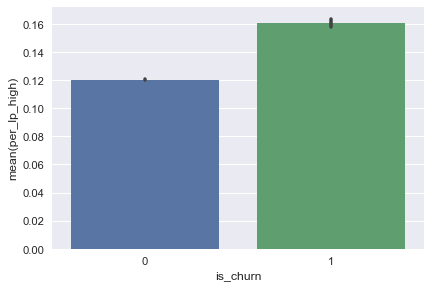

In [82]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'per_lp_high', data=f_txn)

### Percentage of Transactions where Plan List Price is Higher than Actual Amount Paid

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'per_lp_high', data=f_txn)

### Previous Churn

In [ ]:
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('prev_churn_cnt', 'is_churn', data=f_txn)

### % of Transactions as Auto Renew

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'mean_ar', data=f_txn)

### Stopped Auto Renew

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'stopped_ar', data=f_txn)

### Changed Payment Methods

In [ ]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('pmt_change_cnt', 'is_churn', data=f_txn)

### % of Transactions Cancelled

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'mean_cancel', data=f_txn)

### Last Transaction is Cancelled Transaction

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'last_cancel', data=f_txn)

### Last Transaction is Free Trial

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'lst_free_trial', data=f_txn)

In [ ]:
f_txn.corr()